In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import os
# dataset disponivel em https://www.kaggle.com/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri
# Transformações
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root_dir = '/home/guilherme/Documentos/Projetos/Estudos-IC/Deep Learning for CV/Praticing/Brain tumor/Dataset'

# Verifica se o diretório existe
if not os.path.exists(root_dir):
    raise FileNotFoundError(f"O diretório {root_dir} não foi encontrado.")

dataset = datasets.ImageFolder(root=root_dir, transform=transform)

# Verifica classes e índices
print("Número de imagens:", len(dataset))
print("Classes:", dataset.classes)
print("Mapeamento:", dataset.class_to_idx)

# Função para split estratificado
def stratified_split(dataset, train_ratio=0.8):
    targets = np.array([label for _, label in dataset])
    classes, counts = np.unique(targets, return_counts=True)
    train_indices = []
    test_indices = []
    
    for c in classes:
        idx = np.where(targets == c)[0]
        np.random.shuffle(idx)
        split = int(train_ratio * len(idx))
        train_indices.extend(idx[:split])
        test_indices.extend(idx[split:])
    
    return Subset(dataset, train_indices), Subset(dataset, test_indices)

# Divisão estratificada
train_dataset, test_dataset = stratified_split(dataset)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verifica os rótulos
for images, labels in train_loader:
    print("Rótulos no treino:", labels)
    break

for images, labels in test_loader:
    print("Rótulos no teste:", labels)
    break

Número de imagens: 9618
Classes: ['Healthy', 'Tumor']
Mapeamento: {'Healthy': 0, 'Tumor': 1}
Rótulos no treino: tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 1])
Rótulos no teste: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482791].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input dat

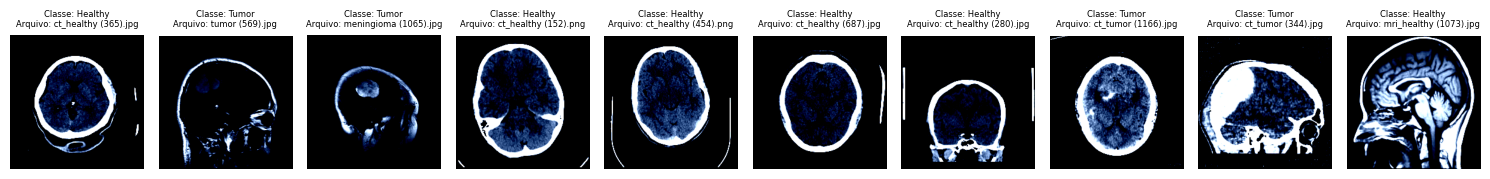

In [35]:
import matplotlib.pyplot as plt
import random

# Função para plotar imagens aleatórias do conjunto de treino
def plot_random_images(dataset, num_images=5):
    random_indices = random.sample(range(len(dataset)), num_images)
    
    # Plota as imagens
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]
        image_path = dataset.dataset.samples[dataset.indices[idx]][0]  
        
        # Converte a imagem de tensor para numpy e desnormaliza (se necessário)
        image = image.permute(1, 2, 0).numpy()  
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Classe: {dataset.dataset.classes[label]}\nArquivo: {os.path.basename(image_path)}", fontsize=6)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plota 5 imagens aleatórias do conjunto de treino
plot_random_images(train_dataset, num_images=10)

In [ ]:
import numpy as np

# Função para contar as classes em um dataset
def count_classes(dataset, class_names):
    if isinstance(dataset, torch.utils.data.Subset):
        labels = [dataset.dataset.targets[i] for i in dataset.indices]
    else:
        labels = dataset.targets
    
    # Conta as ocorrências de cada classe
    class_counts = {class_name: 0 for class_name in class_names}
    for label in labels:
        class_name = class_names[label]
        class_counts[class_name] += 1
    
    return class_counts

class_names = dataset.classes  

# Conta as classes no conjunto de treino
train_class_counts = count_classes(train_dataset, class_names)
print("Distribuição no conjunto de treino:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} imagens")

# Conta as classes no conjunto de teste
test_class_counts = count_classes(test_dataset, class_names)
print("\nDistribuição no conjunto de teste:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count} imagens")

Distribuição no conjunto de treino:
Healthy: 3440 imagens
Tumor: 4254 imagens

Distribuição no conjunto de teste:
Healthy: 860 imagens
Tumor: 1064 imagens


Definindo o modelo

In [15]:
model = torch.nn.Sequential(torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
                            torch.nn.ReLU(),
                            torch.nn.MaxPool2d(kernel_size=2),
                            torch.nn.Flatten(),
                            torch.nn.Linear(16 * 112 * 112, 2),)

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

num_epochs = 5

# Coloca o modelo em modo de treinamento
model.train()

# Loop de treinamento
for epoch in range(num_epochs):
    total_loss = 0
    correct = 0  # Contador de previsões corretas
    total = 0    # Contador total de amostras

    for images, labels in train_loader:  
        # Move os dados para o dispositivo correto
        images, labels = images.to(device), labels.to(device)

        y_pred = model(images)

        loss = loss_fn(y_pred, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acumula a perda para visualização
        total_loss += loss.item()

        # Cálculo da acurácia
        predicted_labels = torch.argmax(y_pred, dim=1)  
        correct += (predicted_labels == labels).sum().item()  
        total += labels.size(0)  

    # Calcula a acurácia média
    accuracy = correct / total * 100

    print(f"Época {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Acurácia: {accuracy:.2f}%")


Época 1/5, Loss: 0.0207, Acurácia: 99.64%
Época 2/5, Loss: 0.0119, Acurácia: 99.84%
Época 3/5, Loss: 0.0073, Acurácia: 99.96%
Época 4/5, Loss: 0.0176, Acurácia: 99.61%
Época 5/5, Loss: 0.0056, Acurácia: 99.99%


In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support 
import numpy as np

def test_model(model, test_loader, device):
    model.eval()  # Coloca o modelo em modo de avaliação
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"\nTest Loss: {total_loss/len(test_loader):.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    
    return {
        'loss': total_loss/len(test_loader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

test_metrics = test_model(model, test_loader, device)


Test Loss: 0.1140
Test Accuracy: 97.09%
Precision: 0.9716
Recall: 0.9696
F1-Score: 0.9705

Confusion Matrix:
[[ 823   37]
 [  19 1045]]
